In [35]:
from robot import *
from da_test_suite_functions import *
import pandas as pd
import cv2
from utils import *

import numpy as np
from scipy.optimize import leastsq
import math
from scipy.spatial.transform import Rotation as R

In [36]:
# df_observations = pd.read_pickle( r'observation_files/obs_TU_meas_marker_stopping_20240602-210607.p')
df_observations = pd.read_pickle( r'observation_files/obs_TU_meas_charuco_stopping_20240602-210425.p')

In [37]:
pip2 = np.pi / 2
theta = np.array([0.0, 0, 0, 0, 0, 0, 0])
d =     np.array([0.0, 0, 0, 0, 0, 0, 0])
r =     np.array([0.0, 0, 0.42, 0, 0.4, 0, 0])
alpha = np.array([-pip2, pip2, -pip2, -pip2, pip2, pip2, -pip2])


# Transform from world frame to frame 0
T_W0 = np.array([[-1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0.36],
                 [0, 0, 0, 1]])

In [38]:
list_R_cam, list_t_cam, list_R_kin, list_t_kin = [], [], [], []
for obs in df_observations.to_dict('records'):
    T_cam = obs['mat']
    R_cam, t_cam = split_H_transform(T_cam)
    list_R_cam.append(R_cam)
    list_t_cam.append(t_cam)
    
    q = np.array(obs['q'])
    T_kin = T_W0 @ RobotDescription.get_T_jk(0, 7, q, theta, d, r, alpha)
    R_kin, t_kin = split_H_transform(T_kin)
    list_R_kin.append(R_kin)
    list_t_kin.append(t_kin)
    

In [39]:
method1 = cv2.CALIB_HAND_EYE_TSAI
method2 = cv2.CALIB_HAND_EYE_PARK
method3 = cv2.CALIB_HAND_EYE_HORAUD
method4 = cv2.CALIB_HAND_EYE_ANDREFF
method5 = cv2.CALIB_HAND_EYE_DANIILIDIS

In [40]:
R_handeye, t_handeye = cv2.calibrateHandEye(list_R_kin, list_t_kin, list_R_cam, list_t_cam, method=method1)
print(f"t_handeye:\n{t_handeye}")

rot = R.from_matrix(R_handeye)
rotvec = rot.as_euler('xyz')
print(f"rot euler:\n{rotvec}")

T_handeye = merge_H_transform(R_handeye, t_handeye)


t_handeye:
[[ 0.06302042]
 [-0.02979962]
 [-0.13033521]]
rot euler:
[-0.03967394 -1.24973457 -0.05827529]


In [41]:
def calc_matrix(params):
    theta__7, r__7, theta__8, r__8, alpha__8, d__8 = params
    return np.mat([[math.cos(theta__7) * math.cos(theta__8) - math.sin(theta__7) * math.cos(alpha__8) * math.sin(theta__8),-math.cos(theta__7) * math.sin(theta__8) - math.sin(theta__7) * math.cos(alpha__8) * math.cos(theta__8),math.sin(theta__7) * math.sin(alpha__8),math.sin(theta__7) * math.sin(alpha__8) * r__8 + math.cos(theta__7) * d__8],[math.sin(theta__7) * math.cos(theta__8) + math.cos(theta__7) * math.cos(alpha__8) * math.sin(theta__8),math.cos(theta__7) * math.cos(alpha__8) * math.cos(theta__8) - math.sin(theta__7) * math.sin(theta__8),-math.cos(theta__7) * math.sin(alpha__8),-math.cos(theta__7) * math.sin(alpha__8) * r__8 + d__8 * math.sin(theta__7)],[math.sin(alpha__8) * math.sin(theta__8),math.sin(alpha__8) * math.cos(theta__8),math.cos(alpha__8),math.cos(alpha__8) * r__8 + r__7],[0,0,0,1]])

def eq(params, res):
    mat = np.array(calc_matrix(params)-res)
    return mat.flatten()

def reduce_rotations(theta):
    if theta > np.pi:
        theta = theta % (2*np.pi)
    if theta < -np.pi:
        theta = theta % -(2*np.pi)
    return theta

def find_mdh_params_6d(mat, initial_guesses = (0, 0, 0, 0, 0, 0), verbose=False):
    if verbose:
        print(f"Target Matrix:\n")
        roundprint(np.array(mat))
    res = leastsq(eq, initial_guesses, args=mat)[0]
    
    
    if False:
        results = zip(["theta__7", "r__7", "theta__8", "r__8", "alpha__8", "d__8" ], res)
        print(f"Results:")
        for elem in results:
            print("\t"+elem[0]+" :\t\t"+f"{elem[1]:.2f}")
        print(f"\nCheck Matrix:")
        roundprint(np.array(calc_matrix(tuple(res))))
        
    # modulo for the angles
    res2 = res.copy()
    res2[0] = reduce_rotations(res2[0])
    res2[2] = reduce_rotations(res2[2])
    res2[4] = reduce_rotations(res2[4])
    
    if verbose:
        results = zip(["theta__7", "r__7", "theta__8", "r__8", "alpha__8", "d__8" ], res2)
        print(f"Results Modulo:")
        for elem in results:
            print("\t"+elem[0]+" :\t\t"+f"{elem[1]:.2f}")
        print(f"\nCheck Matrix Modulo:")
        roundprint(np.array(calc_matrix(tuple(res2))))
    print("residue")
    roundprint(np.array(calc_matrix(tuple(res2)))-mat)
    return res2

In [42]:
find_mdh_params_6d(T_handeye, initial_guesses = (0, 0, 0, 0, 0, 0), verbose=True)

Target Matrix:

 0.315  0.096 -0.944  0.063 
-0.018  0.995  0.095 -0.030 
 0.949 -0.013  0.315 -0.130 
 0.000  0.000  0.000  1.000 


Results Modulo:
	theta__7 :		1.47
	r__7 :		-0.11
	theta__8 :		-1.56
	r__8 :		-0.07
	alpha__8 :		-1.25
	d__8 :		-0.02

Check Matrix Modulo:
 0.315  0.096 -0.944  0.063 
-0.018  0.995  0.095 -0.030 
 0.949 -0.013  0.315 -0.130 
 0.000  0.000  0.000  1.000 


residue
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 
 0.000  0.000  0.000  0.000 




array([ 1.47071305, -0.10851038, -1.55760626, -0.06921356, -1.24999626,
       -0.02335374])

In [43]:
locations = []
for obs in df_observations.to_dict('records'):
    T_CM = obs['mat']
    # q = np.concatenate([np.array(obs['q']),np.zeros(1)])
    # loc = RobotDescription.get_marker_location(T_CM, q, dhparams['theta_nom'], dhparams['d_nom'], dhparams['r_nom'], dhparams['alpha_nom'])
    # R, t = split_H_transform(loc)
    
    q = np.array(obs['q'])
    T_kin = T_W0 @ RobotDescription.get_T_jk(0, 7, q, theta, d, r, alpha) @ np.linalg.inv(T_handeye) @ T_CM
    R, t = split_H_transform(T_kin)
    locations.append(t)

In [44]:
# dhparams = {"theta_nom": np.array([0.0, 0, 0, 0, 0, 0, 1.47, -1.56]),
#             "d_nom": np.array([0.0, 0, 0, 0, 0, 0, 0, -0.02]),
#             "r_nom": np.array([0, 0, 0.42, 0, 0.4, 0, -0.11, -0.07]),
#             "alpha_nom": np.array([-pip2, pip2, -pip2, -pip2, pip2, pip2, -pip2, -1.25]),
#             "num_joints": 7,
#             "num_cam_extrinsic": 1}  # camera extrinsic calib

# locations = []
# for obs in df_observations.to_dict('records'):
#     T_CM = obs['mat']
#     q = np.concatenate([np.array(obs['q']),np.zeros(1)])
#     loc = RobotDescription.get_marker_location(T_CM, q, dhparams['theta_nom'], dhparams['d_nom'], dhparams['r_nom'], dhparams['alpha_nom'])
#     R, t = split_H_transform(loc)
#     locations.append(t)

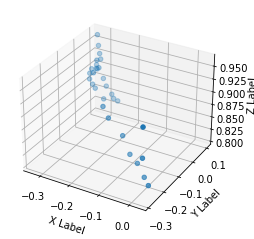

In [45]:
locations = np.array(locations)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(locations[:,0], locations[:,1], locations[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()